## Customer Segmentation

Kaggle Data: https://www.kaggle.com/datasets/vetrirah/customer

The data has already been split into train and test set.

The work is split into 4 files: 
- 1_main_eda.ipynb (current one)
- 2_cleaning.ipynb
- 3_kmeans.ipynb 
- 4_experimentation.ipynb

In [1]:
## import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

import scipy.stats as ss
from itertools import combinations
from scipy.stats import chi2_contingency

## Loading the dataset

In [2]:
## loading data
df = pd.read_csv('data/train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


## Descriptive Analysis

In [3]:
df.info()
## there are 8068 records and 10 columns 
## 6 categorical variables and remaining 4 numeric variables
## 2 float columns and 2 integer columns 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


### explanation of the variables

- ID: Unique ID
- Gender: Gender of the customer
- Ever_Married: Marital status of the customer
- Age: Age of the customer
- Graduated: Is the customer a graduate ?
- Profession: Profession of the customer
- Work_Experience: Work Experience in years
- Spending_Score: Spending score of the customer
- Family_Size: Number of family members for the customer (including the customer)
- Var_1: Anonymised Category for the customer


In [4]:
## checking misssing values: many missing values
df.isnull().sum() 

# ever_married : 140
# gradauted: 78
# profession : 124
# work_experience: 124
# family_size: 335
# var_1: 76

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [5]:
## we won't be removing any rows as our dataset is small
# we will later replace with the median/mean/mode
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({
                                 'percent_missing': percent_missing.round(2)})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df 


,percent_missing
Work_Experience,10.28
Family_Size,4.15
Ever_Married,1.74
Profession,1.54
Graduated,0.97
Var_1,0.94
ID,0.00
Gender,0.00
Age,0.00
Spending_Score,0.00


In [6]:
## statistics of variables
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [7]:
## checking for duplicates: no duplicates
df['ID']. nunique() # 8086 same as 8086 rows

8068

In [8]:
## explore unique values for each column
column_names = list(df.columns)
for col in column_names:
    print(col, ':', df[col].nunique(), )

ID : 8068
Gender : 2
Ever_Married : 2
Age : 67
Graduated : 2
Profession : 9
Work_Experience : 15
Spending_Score : 3
Family_Size : 9
Var_1 : 7
Segmentation : 4


In [9]:
## convert all column names to lower case for ease of typing
df.columns = df.columns.str.lower()

## Explorative Analysis

### Categorical columns: 6 columns

Most of the customers of the automobile company is:
- 54.75% male
- 57.55% married
- 61.58% a graduate
- 31.18% an artist
- 60.46% of a low spender score
- 64.92% in an anonymised category 6


In [10]:
## the categorical sub-dataset
cat_col = df.select_dtypes(include=['object'])
cat_col 

,gender,ever_married,graduated,profession,spending_score,var_1,segmentation
0,Male,No,No,Healthcare,Low,Cat_4,D
1,Female,Yes,Yes,Engineer,Average,Cat_4,A
2,Female,Yes,Yes,Engineer,Low,Cat_6,B
3,Male,Yes,Yes,Lawyer,High,Cat_6,B
4,Female,Yes,Yes,Entertainment,High,Cat_6,A
...,...,...,...,...,...,...,...
8063,Male,No,No,NaN,Low,Cat_1,D
8064,Male,No,No,Executive,Low,Cat_4,D
8065,Female,No,Yes,Healthcare,Low,Cat_6,D
8066,Female,No,Yes,Healthcare,Low,Cat_6,B


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/580012784.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0.0, '0%'),
 Text(0, 10.0, '10%'),
 Text(0, 20.0, '20%'),
 Text(0, 30.0, '30%'),
 Text(0, 40.0, '40%'),
 Text(0, 50.0, '50%'),
 Text(0, 60.0, '60%')]

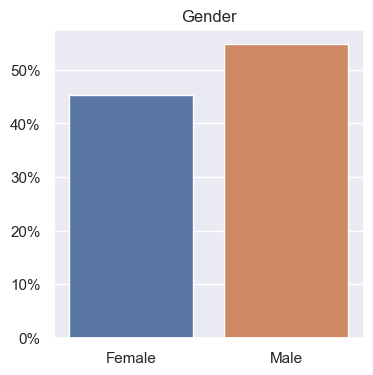

In [11]:
## 1- Gender distribution

gender = pd.DataFrame(df.groupby(["gender"]).size().reset_index(name="Count"))
gender['Percentage'] = round(gender['Count'] *100/ len(df),2)


plt.figure(figsize=(4,4))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'gender', y = 'Percentage',data=gender)
ax.set_title('Gender')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])


In [12]:
gender

,gender,Count,Percentage
0,Female,3651,45.25
1,Male,4417,54.75


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/3364826611.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0, 'Not married'), Text(1, 0, 'Married')]

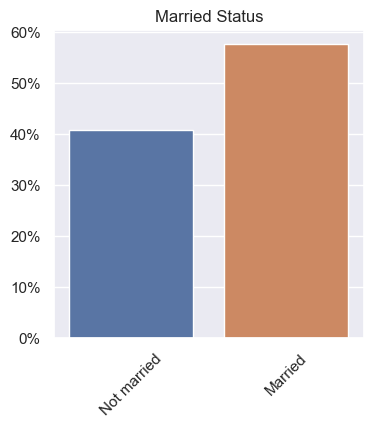

In [13]:
## 2 - Ever_married distribution

ever_married = pd.DataFrame(df.groupby(["ever_married"]).size().reset_index(name="Count"))
ever_married['Percentage'] = round(ever_married['Count'] *100/ len(df),2)

plt.figure(figsize=(4,4))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'ever_married', y = 'Percentage',data=ever_married)
ax.set_title('Married Status')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
ax.set_xticklabels(['Not married','Married'], rotation =45)


In [14]:
ever_married 

,ever_married,Count,Percentage
0,No,3285,40.72
1,Yes,4643,57.55


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/3358097344.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0, 'Not a graduate'), Text(1, 0, 'A graduate')]

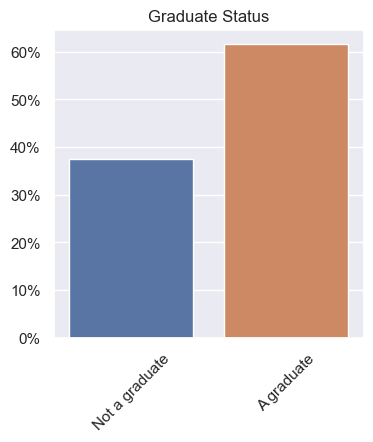

In [15]:
## 3 - Graduate distribution

graduated = pd.DataFrame(df.groupby(["graduated"]).size().reset_index(name="Count"))
graduated['Percentage'] = round(graduated['Count'] *100/ len(df),2)

plt.figure(figsize=(4,4))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'graduated', y = 'Percentage',data=graduated)
ax.set_title('Graduate Status')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
ax.set_xticklabels(['Not a graduate','A graduate'], rotation =45)

In [16]:
graduated

,graduated,Count,Percentage
0,No,3022,37.46
1,Yes,4968,61.58


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/3022514729.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0, 'Artist'),
 Text(1, 0, 'Healthcare'),
 Text(2, 0, 'Entertainment'),
 Text(3, 0, 'Engineer'),
 Text(4, 0, 'Doctor'),
 Text(5, 0, 'Lawyer'),
 Text(6, 0, 'Executive'),
 Text(7, 0, 'Marketing'),
 Text(8, 0, 'Homemaker')]

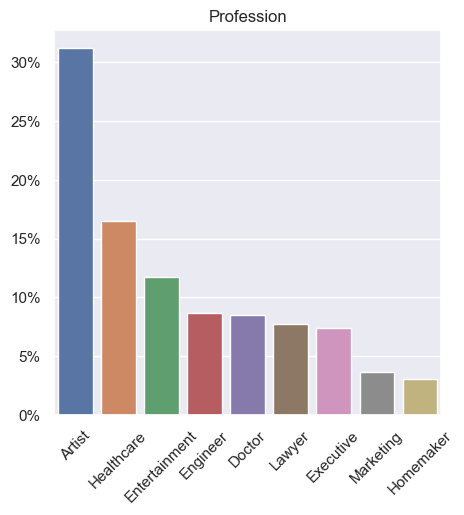

In [17]:
## 4 - Profession distribution

profession = pd.DataFrame(df.groupby(["profession"], dropna= True).size().reset_index(name="Count").sort_values('Count', ascending= False))
profession['Percentage'] = round(profession['Count'] *100/ len(df),2)

plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'profession', y = 'Percentage',data=profession)
ax.set_title('Profession')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
ax.set_xticklabels( profession["profession"].tolist(), rotation =45)


In [18]:
profession

,profession,Count,Percentage
0,Artist,2516,31.18
5,Healthcare,1332,16.51
3,Entertainment,949,11.76
2,Engineer,699,8.66
1,Doctor,688,8.53
7,Lawyer,623,7.72
4,Executive,599,7.42
8,Marketing,292,3.62
6,Homemaker,246,3.05


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/83548188.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0.0, '0%'),
 Text(0, 10.0, '10%'),
 Text(0, 20.0, '20%'),
 Text(0, 30.0, '30%'),
 Text(0, 40.0, '40%'),
 Text(0, 50.0, '50%'),
 Text(0, 60.0, '60%'),
 Text(0, 70.0, '70%')]

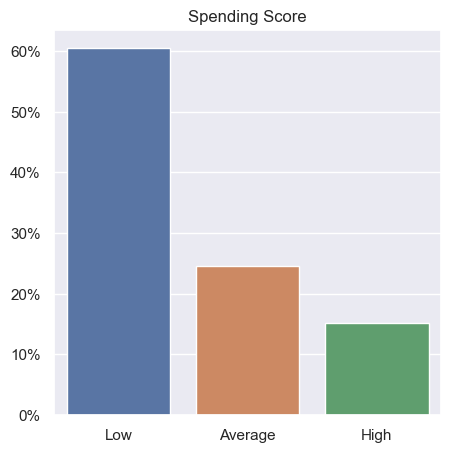

In [19]:
## 5 - Spending score distribution

spending_score = pd.DataFrame(df.groupby(["spending_score"]).size().reset_index(name="Count").sort_values('Count', ascending= False))
spending_score['Percentage'] = round(spending_score['Count'] *100/ len(df),2)

plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'spending_score', y = 'Percentage',data=spending_score)
ax.set_title('Spending Score')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])



In [20]:
spending_score

,spending_score,Count,Percentage
2,Low,4878,60.46
0,Average,1974,24.47
1,High,1216,15.07


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/4096532214.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0.0, '0%'),
 Text(0, 10.0, '10%'),
 Text(0, 20.0, '20%'),
 Text(0, 30.0, '30%'),
 Text(0, 40.0, '40%'),
 Text(0, 50.0, '50%'),
 Text(0, 60.0, '60%'),
 Text(0, 70.0, '70%')]

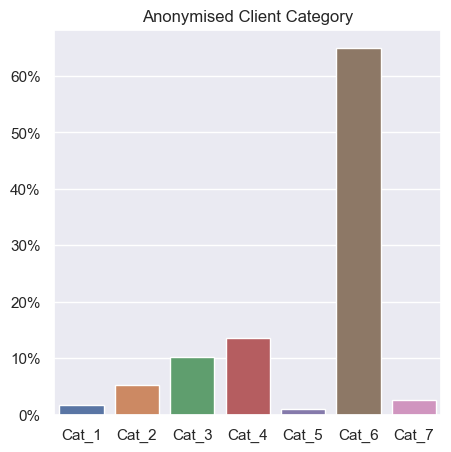

In [21]:
## 6 - Var_1 distribution
# var_1 is anonymised category of clients

var_1 = pd.DataFrame(df.groupby(["var_1"]).size().reset_index(name="Count"))
var_1['Percentage'] = round(var_1['Count'] *100/ len(df),2)

plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'var_1', y = 'Percentage',data=var_1)
ax.set_title('Anonymised Client Category')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])


In [22]:
var_1

,var_1,Count,Percentage
0,Cat_1,133,1.65
1,Cat_2,422,5.23
2,Cat_3,822,10.19
3,Cat_4,1089,13.50
4,Cat_5,85,1.05
5,Cat_6,5238,64.92
6,Cat_7,203,2.52


### relationships beween categorical variables using Cramer V

- a: ever_married have the highest correlation at 0.68 with spending_score
    - non-married people are all low-spenders (40%) compared to married people who fall in the 3 categories
- b: ever_married and profession at 0.52
    - single artists (22%) and married healthcarers (14%) are the biggest customers 
- c: spending_score and profession : 0.44
    - artist & healthcare are the biggest customers in the low-spending-score
    - artists are the biggest customers in the mid-spending-score
    - executives & lawyers are the biggest customers in the high-spending-score
- profession and graduated : 0.41
- profession and gender : 0.36



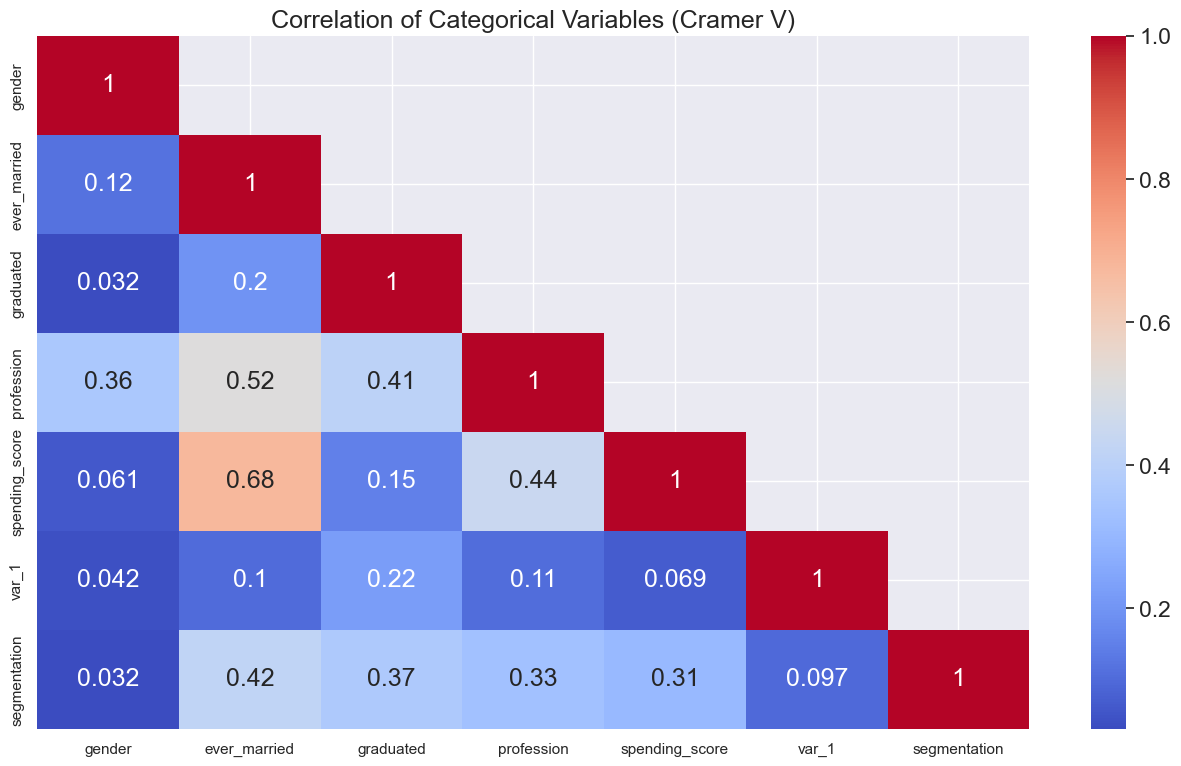

In [23]:
## Correlation Matrix of categorical variables using Cramer V

# values from 0 to 1 in heatmap where 0 means no association and 1 mean high association
# segmentation has the lowest correlation with gender and var_1 so could be removed later on

import scipy.stats as ss
from itertools import combinations
from scipy.stats import chi2_contingency

cat_col = df.select_dtypes(include=['object'])
cat_col 

def get_corr_mat(df, f=chi2_contingency):
        columns = df.columns
        dm = pd.DataFrame(index=columns, columns=columns)
        for var1, var2 in combinations(columns, 2):
            cont_table = pd.crosstab(df[var1], df[var2], margins=False)
            chi2_stat = cramers_v(cont_table.values)
            dm.loc[var2, var1] = chi2_stat
            dm.loc[var1, var2] = chi2_stat
        dm.fillna(1, inplace=True)
        return dm

def cramers_v(confusion_matrix):
        """ calculate Cramers V statistic for categorial-categorial association.
            uses correction from Bergsma and Wicher,
            Journal of the Korean Statistical Society 42 (2013): 323-328
        """
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_corr= get_corr_mat(cat_col)
fig, ax = plt.subplots(figsize=(16,9))
mask = np.triu(cat_corr,k=1)
sns.set(font_scale=1.5)
sns.heatmap(cat_corr, annot = True, mask=mask, cmap='coolwarm')
ax.set_title('Correlation of Categorical Variables (Cramer V)')

plt.show()


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/573246301.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0, 'Not married'), Text(1, 0, 'Married')]

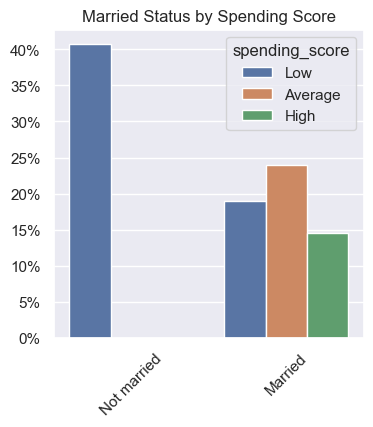

In [24]:
##  a: relationship between married status and spending_score category
ever_married_spending_score = pd.DataFrame(df.groupby(["ever_married",'spending_score']).size().reset_index(name="Count"))
ever_married_spending_score['Percentage'] = round(ever_married_spending_score['Count'] *100/ len(df),2)

plt.figure(figsize=(4,4))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'ever_married', y = 'Percentage',data=ever_married_spending_score, hue='spending_score',)
ax.set_title('Married Status by Spending Score')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
ax.set_xticklabels(['Not married','Married'], rotation =45)

In [25]:
ever_married_spending_score

,ever_married,spending_score,Count,Percentage
0,No,Low,3285,40.72
1,Yes,Average,1937,24.01
2,Yes,High,1176,14.58
3,Yes,Low,1530,18.96


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/3298160727.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0.0, '0%'),
 Text(0, 5.0, '5%'),
 Text(0, 10.0, '10%'),
 Text(0, 15.0, '15%'),
 Text(0, 20.0, '20%'),
 Text(0, 25.0, '25%')]

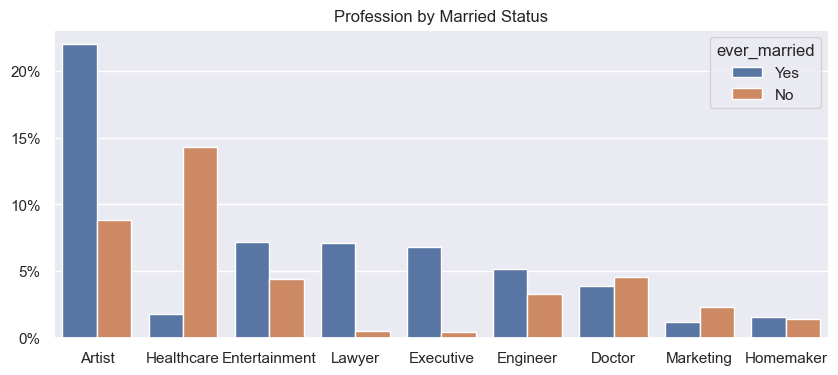

In [26]:
## b: relationship between married status and profession
ever_married_profession = pd.DataFrame(df.groupby(["ever_married",'profession']).size().reset_index(name="Count").sort_values('Count', ascending= False))
ever_married_profession['Percentage'] = round(ever_married_profession['Count'] *100/ len(df),2)

plt.figure(figsize=(10,4))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'profession', y = 'Percentage',data=ever_married_profession, hue='ever_married')
ax.set_title('Profession by Married Status')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])

In [27]:
ever_married_profession.head(5)

,ever_married,profession,Count,Percentage
9,Yes,Artist,1774,21.99
5,No,Healthcare,1153,14.29
0,No,Artist,713,8.84
12,Yes,Entertainment,579,7.18
16,Yes,Lawyer,575,7.13


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/1794040977.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


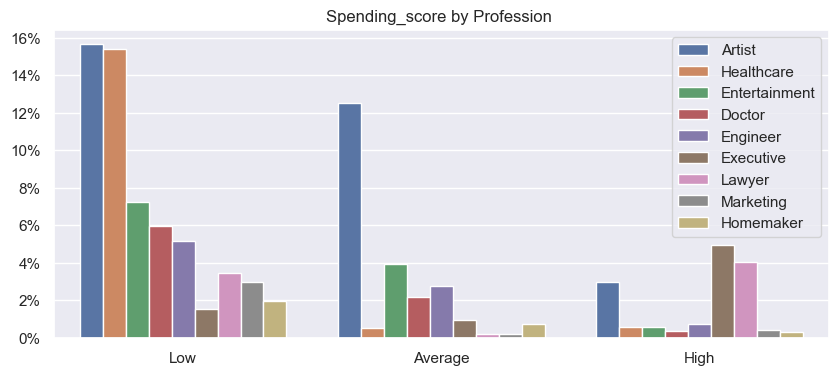

In [28]:
## c: relationship between spending_score and profession
spending_score_profession = pd.DataFrame(df.groupby(["spending_score",'profession']).size().reset_index(name="Count").sort_values('Count', ascending= False))
spending_score_profession['Percentage'] = round(spending_score_profession['Count'] *100/ len(df),2)

plt.figure(figsize=(10,4))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'spending_score', y = 'Percentage',data=spending_score_profession, hue='profession')
ax.set_title('Spending_score by Profession ')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
plt.legend(loc='upper right')

In [29]:
spending_score_profession.head(5)

,spending_score,profession,Count,Percentage
18,Low,Artist,1263,15.65
23,Low,Healthcare,1245,15.43
0,Average,Artist,1011,12.53
21,Low,Entertainment,584,7.24
19,Low,Doctor,480,5.95


### numerical variables: 

- About 50% of customers are below 40 years old. 
- Almost 60% of customers have 1 year work experience or less.
- About 30% of customers are in a family size of 3 including themselves.

The customers seem to be on the young side.

There are also outliers which would be replaced with the upper bound

In [30]:
## the numerical sub-dataset
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_col = df.select_dtypes(include=numerics)
num_col 


,id,age,work_experience,family_size
0,462809,22,1.0,4.0
1,462643,38,NaN,3.0
2,466315,67,1.0,1.0
3,461735,67,0.0,2.0
4,462669,40,NaN,6.0
...,...,...,...,...
8063,464018,22,0.0,7.0
8064,464685,35,3.0,4.0
8065,465406,33,1.0,1.0
8066,467299,27,1.0,4.0


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/1754780765.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i[1]])
/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/1754780765.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i[1]])
/var/folders/j8/vzdf

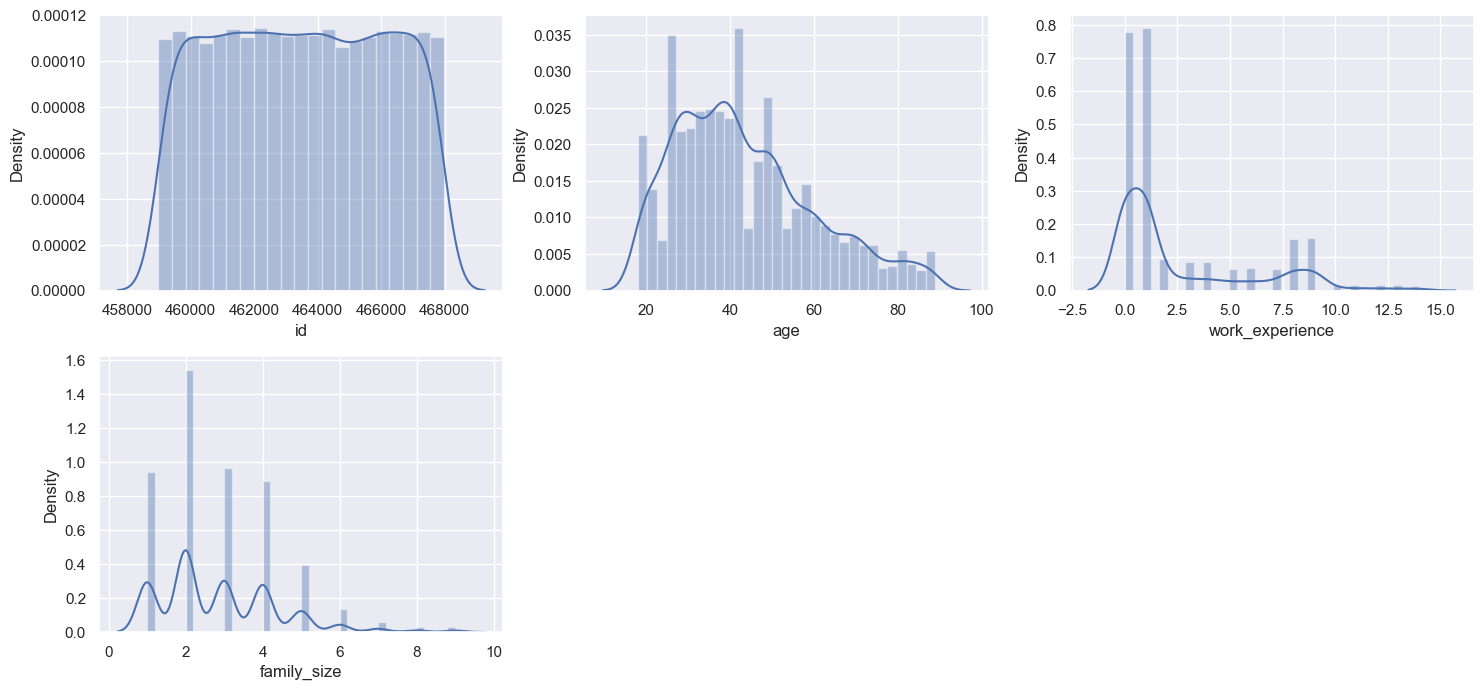

In [31]:
#quick distribution of each numerical feature or the world's current level
plt.figure(figsize=(15,10))
for i in enumerate(num_col):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(df[i[1]])

plt.tight_layout()

[Text(0.5, 0, 'Years'), Text(0, 0.5, '')]

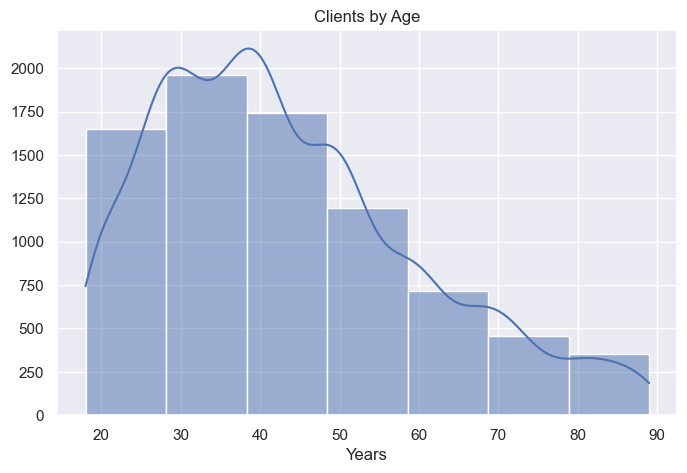

In [32]:
## age histogram

age = pd.DataFrame(df.groupby(["age"]).size().reset_index(name="Count"))

plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
ax = sns.histplot(x = 'age',data=num_col, kde=True, bins = 7)
ax.set_title('Clients by Age')
ax.set( xlabel= 'Years', ylabel= None)

## bins of 7 which mean the bucket is of about 10 years.

In [33]:
age.sort_values('Count', ascending= False)

## min is 18 and max is 89

,age,Count
15,35,250
17,37,234
22,42,232
14,33,232
20,40,229
...,...,...
55,78,29
64,87,28
53,76,27
57,80,24


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/670002673.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0.0, '0%'),
 Text(0, 5.0, '5%'),
 Text(0, 10.0, '10%'),
 Text(0, 15.0, '15%'),
 Text(0, 20.0, '20%'),
 Text(0, 25.0, '25%'),
 Text(0, 30.0, '30%'),
 Text(0, 35.0, '35%')]

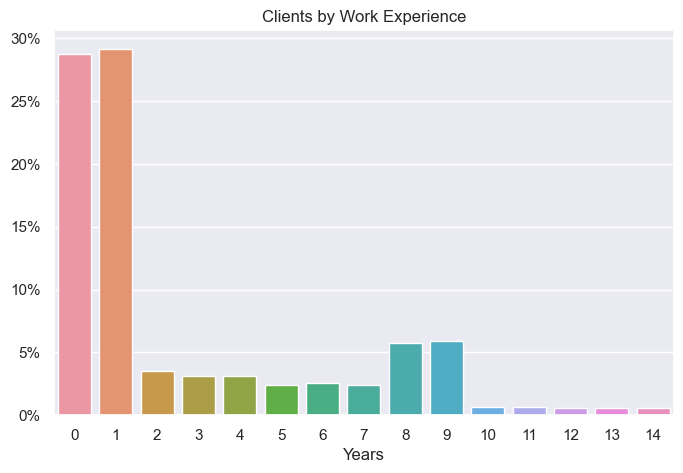

In [34]:
## Work Experience Distribution

work_experience = pd.DataFrame(df.groupby(["work_experience"]).size().reset_index(name="Count"))
work_experience['Percentage'] = round(work_experience['Count'] *100/ len(df),2)
work_experience['work_experience'] = work_experience['work_experience'].astype(int)

plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'work_experience', y = 'Percentage',data=work_experience)
ax.set_title('Clients by Work Experience')
ax.set( xlabel= 'Years', ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])

In [35]:
work_experience['work_experience'] = work_experience['work_experience'].astype(int)
work_experience

,work_experience,Count,Percentage
0,0,2318,28.73
1,1,2354,29.18
2,2,286,3.54
3,3,255,3.16
4,4,253,3.14
5,5,194,2.40
6,6,204,2.53
7,7,196,2.43
8,8,463,5.74
9,9,474,5.88


/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_81268/2733699004.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:g}%' for x in vals])


[Text(0, 0.0, '0%'),
 Text(0, 5.0, '5%'),
 Text(0, 10.0, '10%'),
 Text(0, 15.0, '15%'),
 Text(0, 20.0, '20%'),
 Text(0, 25.0, '25%'),
 Text(0, 30.0, '30%'),
 Text(0, 35.0, '35%')]

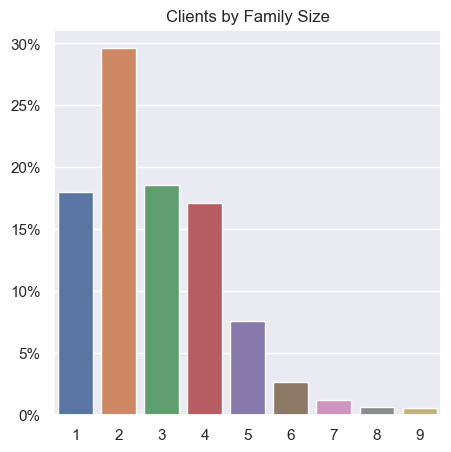

In [36]:
## Family size distribution

family_size = pd.DataFrame(df.groupby(["family_size"]).size().reset_index(name="Count"))
family_size['Percentage'] = round(family_size['Count'] *100/ len(df),2)
family_size['family_size'] = family_size['family_size'].astype(int)


plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = 'family_size', y = 'Percentage',data=family_size)
ax.set_title('Clients by Family Size')
ax.set( xlabel= None, ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])

In [37]:
family_size

,family_size,Count,Percentage
0,1,1453,18.01
1,2,2390,29.62
2,3,1497,18.55
3,4,1379,17.09
4,5,612,7.59
5,6,212,2.63
6,7,96,1.19
7,8,50,0.62
8,9,44,0.55


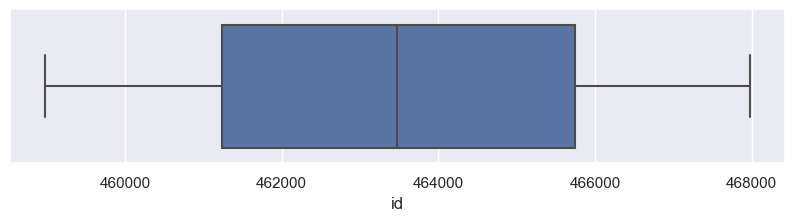

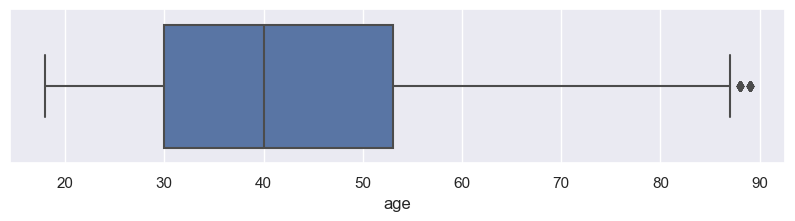

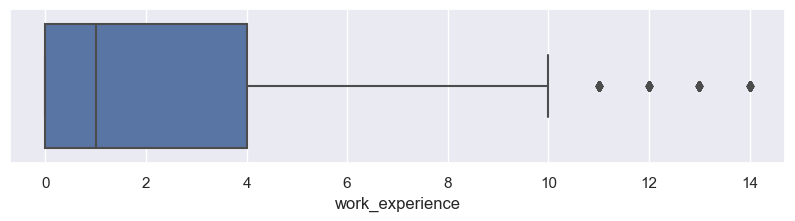

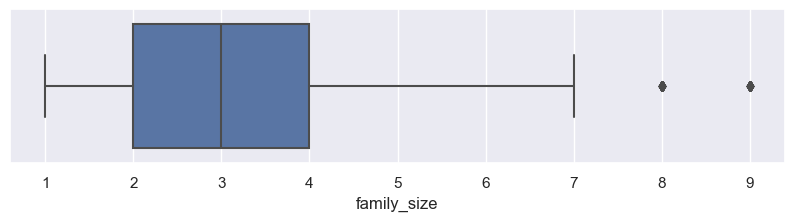

In [38]:
## explore distribution of each characteristic using boxplots 
# choose outliers with showfliers=False/True
for column in num_col:
    plt.figure(figsize=(10,2))
    #df.boxplot([column])
    sns.boxplot(data=df, x=column, showfliers= True) # set showfliers to False to remove outliers

### Correlation Matrix

No strong correlation between numerical variables so won't be exploring further

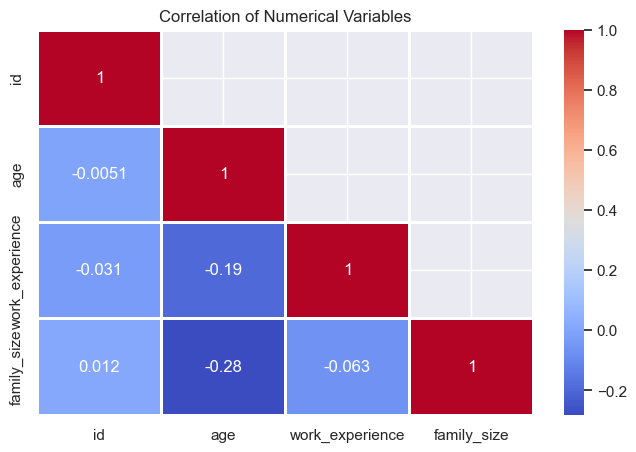

In [39]:
## The correlation matrix
corr_mat = df.corr(numeric_only=True)
corr_mat

plt.figure(figsize=(8,5))
mask = np.triu(corr_mat,k=1)
sns.heatmap(corr_mat, annot=True, linewidths=1, mask=mask, cmap='coolwarm')
#sns.set(font_scale=1.2)
plt.title('Correlation of Numerical Variables')
plt.show()

## Next: go to 2_cleaning.ipynb for the cleaning stage